# Introduction

A machine learning project aimed at diagnosing skin cancer through the analysis of skin lesion images represents an exciting and impactful application of artificial intelligence (AI) in healthcare. Skin cancer, being one of the most common types of cancer globally, necessitates early detection and treatment to improve patient outcomes. This project seeks to leverage the advancements in machine learning and image processing to create a model capable of accurately identifying and classifying various types of skin cancer, including melanoma, which is the deadliest form.

This report will utilize the **Universal Workflow of Machine Learning**[<a href="#ref-fc-dlwp">1</a>][1] to build a final model that produces the best results of the chosen dataset using exclusively `Dense` and `Dropout` layers as outlined by the instructions for this final

# Background

Skin cancer classification has traditionally been performed by dermatologists through visual examination and dermatoscopic analysis. However, this process can be subjective and depends heavily on the clinician's experience. With the rise of deep learning, particularly Convolutional Neural Networks (CNNs), there's an opportunity to augment the diagnostic process, offering a second opinion that's quick, scalable, and potentially more accurate in certain contexts.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions

The most common kind of cancer is skin cancer. Even though melanoma is the rarest type of skin cancer, it accounts for 75% of skin cancer-related deaths. In 2020, the American Cancer Society predicts that more than 100,000 new cases of melanoma will be identified. It is anticipated that the illness would claim the lives of about 7,000 individuals. Similar to other malignancies, treatment can be more successful if there is early and precise detection, which may be made possible by data analytics.

# Objectives

- Develop a Machine Learning Model: To train a CNN that can classify skin lesion images into benign and malignant categories, as well as identify specific types of skin cancer.
- Dataset Utilization: To utilize a comprehensive dataset of dermatoscopic images, ensuring the model learns from high-quality, varied examples of different skin types and cancer stages.
- Accuracy and Reliability: To achieve a high degree of accuracy and reliability in classification, comparable or superior to traditional methods employed by dermatologists.

# Methodology

Over the years, it has been noted that patients with similar cancer types exhibit hidden patterns. Deep learning networks have also been found to be particularly good at modeling patterns that are not immediately obvious.

This project aims to correctly identify images of skin lesions as one of the following:
- Melanoma
- Melanocytic nevus
- Basal cell carcinoma
- Actinic keratosis
- Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- Dermatofibroma
- Vascular lesion
- Squamous cell carcinoma
- None of the above

This is going to use the "Skin Lesion Images for Melanoma Classification" dataset, which is a public licenced dataset hosted by kaggle which is based on the 2019 International Skin Imaging Collaboration (ISIC) dataset.
 - https://www.kaggle.com/datasets/andrewmvd/isic-2019
 
Tensorflow, Keras, and Python will be used for the analysis of this dataset. Training a deep learning network to effectively model the patterns of the skin lesions is the goal. In order to investigate the design and building of deep learning networks, this study will employ a deductive approach, starting with a model that can outperform the common sense baseline.

### Dataset Description

This dataset is hosted by kaggle: https://www.kaggle.com/datasets/andrewmvd/isic-2019
The ISIC dataset has 6,834 Registered Users 
With 76,108 Public Images and 240,655 Total Images https://www.isic-archive.com/

There are 25,331 photos in the ISIC 2019 dataset (which includes pictures from 2017 and 2018) that can be used to classify dermoscopic images into nine distinct diagnostic categories. This is the data subset that will be used in this project.

The following python packages will meused to model and display the images:

### Setup Jupyter Environment

The following section handles the installation of all required dependencies used when running the experimentation with **Tensorflow** and **Keras**<br />

In [2]:
# system
import os
import pathlib

# Mathematical Computation
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline

import matplotlib.pyplot as plt #used for plotting and analyzing data

#used for image display
import PIL 
from PIL import Image

from pathlib import Path

from tqdm import tqdm

# Machine Learning Library
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import (layers, models, losses, optimizers, regularizers, callbacks)
from typing import List, Dict, Tuple, Callable, Union, Optional, Any

import functools
import itertools
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


# plotting
import matplotlib.pyplot as plt
import seaborn as sns

The data was processed into a format suitable for Tensorflow, graph learning model output, and image decoding for simple presentation using the following assistance routines.

Initially, some hyper parameters are defined for training use. Not all hyper parameters are defined below, because some of them (e.g.: `learning_rate`)<br />
are far too specific to some components of the architecture (e.g.: the `optimiser`).

In [1]:
# This sets the defaault hyperparameters used for the training 
# this can be overriden by passing in the specific hyperparameter names as arguements

train_hyperparams = dict(
    epochs=100,
    batch_size=512,
)

### Helper Functions

In [2]:
#             Image Processing
#----------------------------------------------#

# decode image
def decode_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img)
    
    # normalize the image
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (224,224))
    
    # convert image from grayscale to rgb (some images are grayscale and others are RGB)
    if tf.shape(img)[2] == tf.convert_to_tensor(1): 
        img = tf.image.grayscale_to_rgb(img)
    return img

# ouputting the image and class label
def convert_ds(file_path):
    img = decode_image(file_path)
    label = tf.strings.split(file_path, os.path.sep)[-2] == classes
    return img, tf.argmax(label)

#            Image Display
#----------------------------------------------#
#draws a grid on the image display
sns.set(style="whitegrid")

# Displays a single image with class label
def show_single(img, label):
    plt.imshow(img)
    plt.title(label)
    
# Displays a grid of sample images with attached class labels
def show_batch(img_batch, label_batch):
    figure = plt.figure(figsize=(12, 10))
    n = 16
    sqrt = int(np.sqrt(n))
    for i in range(n):
        _ = plt.subplot(sqrt, sqrt, i + 1)
        show_single(img_batch[i], classes[label_batch[i]])
        plt.axis('off')
    plt.show()

#             Dataset Orginisation
#----------------------------------------------#
def configure_for_training(data, is_train=False):
    data = data.cache()
    data = data.shuffle(buffer_size=300)
    data = data.batch(32)
    # if is_train:
        # do some augmentations
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data    
    
#             Callback functions
#----------------------------------------------#
#Displays a spinning icon while the model runs
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        c = ['\b|', '\b/', '\b-', '\b\\'] 
        print(c[epoch % 4], end='')
    def on_epoch_end(self, epoch, logs=None):
        print('\b', end='')

# #stops the training when the model stops changing
# earlystoper = tf.keras.callbacks.EarlyStopping(
#                                             monitor='val_loss', 
#                                             patience=10, 
#                                             verbose=0, 
#                                             mode='auto',
#                                             ## This will ensure the best instance of the model over the validation set.
#                                             restore_best_weights=True)
    
# #store the best model for reuse
# mc = tf.keras.callbacks.ModelCheckpoint(
#                                     'best_model.h5', 
#                                     monitor='val_loss', 
#                                     mode='min', 
#                                     verbose=0)

#           Ploting the Model Output
#----------------------------------------------#
# visualize the training and validation accuracies and losses 
def visualize_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    
    iterations = [i for i in range(EPOCHS)]
    
    plt.plot(iterations, train_loss, label="Training Loss", color="b")
    plt.plot(iterations, val_loss, label="Validation Loss", color="r")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
def visualize_acc(history):
    train_loss = history["acc"]
    val_loss = history["val_acc"]
    
    iterations = [i for i in range(EPOCHS)]
    
    
    plt.plot(iterations, train_loss, label="Training Accuracy", color="b")
    plt.plot(iterations, val_loss, label="Validation Accuracy", color="r")
    plt.title("Training and Validation accuracy")
    plt.legend()
    plt.show()
    
    
# Change made on 29/02/2024   
    
def preprocess_data(features, labels):
    # Convert features to float
    features = tf.cast(features, tf.float32)
    # Convert labels if they are not already in numeric form
    labels = tf.cast(labels, tf.float32)  # Adjust as necessary
    return features, labels

## Loading the dataset

In [3]:
import os
print(os.listdir("./Input"))

['archive (8).zip', 'ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Metadata.csv', 'MLNN-Rubric.pngPNGOpen file.url']


# Problem & Dataset

Classifying raw images into categories is an extremely valuable task, with many different applications and value<br />
across multiple industries[<a href="#ref-cwg-asotaoicbocnn">3</a>].

A classic instance of image classification problems is what can be described as a<br />
**multi-class, single-label classification** problem, where $K$ labels exist and each<br />
document (in this case an image) will have a single class attributed (or "labelled") to it.

Formally:

- $\hat{y} = f(X) = \textbf{argmax } g(\theta, X)_{[k]}, \forall{k \in K=\{ 0...|classes| \}}$, where:
  - $X$ is the input image
  - $f$ is the labeller function
  - $g$ is the model
  - $\theta$ are the trainable parameters of the model
 
This report uses the ISIC 2019 dataset which is available from the **ISICS 2019 Dataset**. This is an external dataset that is not a part of the **Tensorflow Datasets Catalog**[<a href="#ref-ciar10">4</a>]. This dataset presents the problem whereby 25,331 images need to be separated into 9 distict classes.

# Data preparation

### Load and Preprocess the Dataset

#### Load the dataset

In [24]:
csv_file = './Input/ISIC_2019_TrainingGroundTruth.csv'
data_labels = pd.read_csv("./Input/ISIC_2019_Training_GroundTruth.csv", header = 0)

images_path = Path('./Input/ISIC_2019_Training_Input/')


In [25]:
classes = data_labels.columns[1:].values
print(classes)

['MEL' 'NV' 'BCC' 'AK' 'BKL' 'DF' 'VASC' 'SCC' 'UNK']


In [19]:
from pathlib import Path
import pandas as pd
import numpy as np

# Assuming images_path and ground_truth_labels are defined

# 1. Efficiently list image file paths
images = [str(path) for path in images_path.rglob("*.jpg")]


# 2. Preprocess data_labels to create a name-to-label mapping
# Assuming 'image' column has the image names without extension, and labels are in the next column
name_to_label = {
    row['image']: row.iloc[1:].values.argmax()
    for _, row in data_labels.iterrows()
}

# 3. Extract labels using the mapping for faster lookup
labels = [name_to_label[Path(path).stem] for path in images]

# 4. Determine the number of unique classes
num_classes = len(np.unique(labels))

# 5. Assert that each image has a corresponding label
assert len(images) == len(labels), 'Not equal number of images and labels'

In [20]:
print(num_classes)
print(len(images))

8
25331


In [12]:
data_labels

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting the dataset 

In [9]:
# https://www.kaggle.com/code/konstanter/classifying-skin-cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns

# Using train_test_split simplifies the splitting process and automatically handles shuffling
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Creating a DataFrame for visualization
df_train = pd.DataFrame({'labels': y_train, 'split': 'train'})
df_test = pd.DataFrame({'labels': y_test, 'split': 'test'})
df = pd.concat([df_train, df_test])

## Visualization

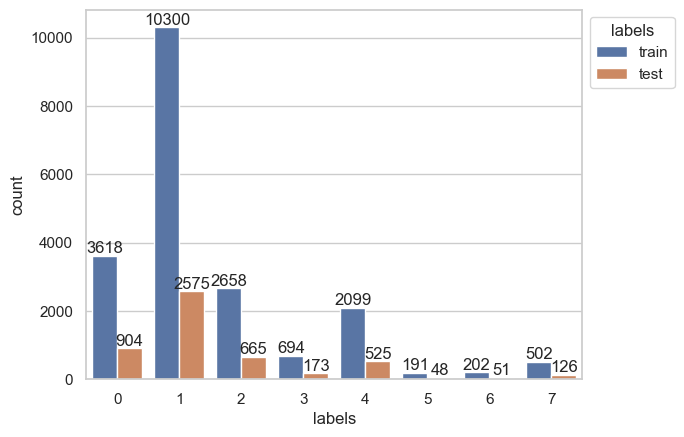

In [10]:
p = sns.countplot(data=df, x='labels', hue='split')
p.legend(title='labels', bbox_to_anchor=(1, 1), loc='upper left')

for c in p.containers:
    p.bar_label(c, fmt='%.0f', label_type='edge')

# Create the Dataset

In [11]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [260, 260], 'nearest')
#     image /= 255
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label   

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(10).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(10).prefetch(tf.data.AUTOTUNE)

### Explore the dataset

In [12]:
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC' : 'Squamous cell carcinoma'
} 

## Get the images and labels

# Model Architecture

In building the baseline model we will start with a simple hold out validation setup of the dataset (train data, test data) in order to test the simplest system for accuracy of prediction. As was stated before this model only needs to perform with an accuracy greater than 33%, or the accuracy of a model randomly guessing one of the 3 class labels.

In [13]:
#             Building the Model
#----------------------------------------------#
def base_model():
    inputs = tf.keras.layers.Input(shape=(260,260,3))

    x = tf.keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    #x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [14]:
base_model = base_model()
base_model.compile(optimizer='adam', 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['acc'])
base_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 258, 258, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 129, 129, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,160 (4.53 KB)

 Trainable params: 1,160 (4.53 KB)

 Non-trainable params: 0 (0.00 B)

From the model summary we can see the model has a total of 1160 trainable parameters for learning the patterns of the data set

In [15]:
EPOCHS = 2
BATCH_SIZE = 32

In [17]:
history = base_model.fit( 
                    train_ds,
                    validation_data=test_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomCallback()])

In [18]:
_, train_acc = base_model.evaluate(train_ds, verbose=0)
_, test_acc = base_model.evaluate(test_ds, verbose=0)
print('Training accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))

Training accuracy: 0.516, Testing accuracy: 0.515


We can see from the previous cell when evaluating the baseline model, it produced a test accuracy that is significantly better than the common sense baseline of approxiamly 33%.

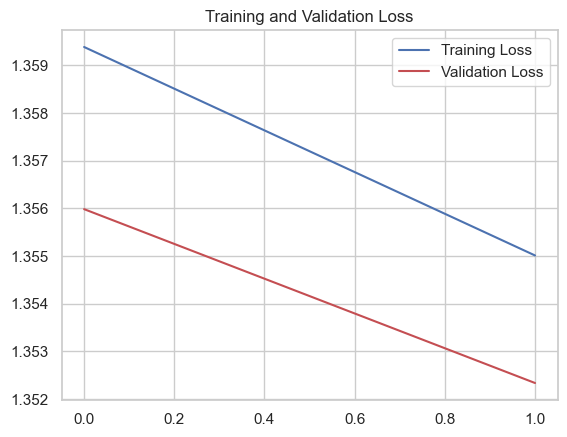

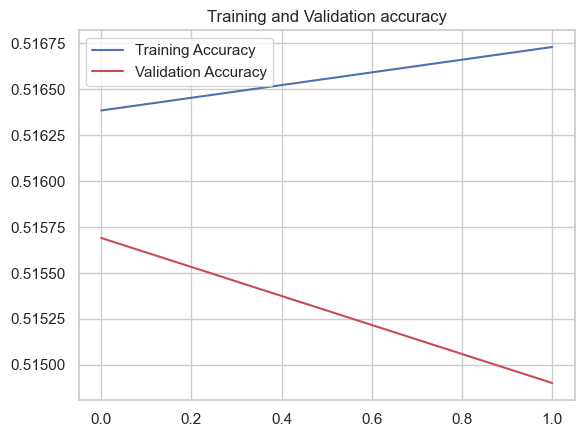

In [19]:
visualize_loss(history.history)
visualize_acc(history.history)

However, from inspecting the graphed training and validation key features:
* Loss 
* Accuracy

It has been shown that the model had not yet converged on its optimal number of epochs for training. Or rather the point where the validation loss and training loss converge before overfitting. To find the point of convergence the number of training epochs will be increased to 600. 

## Training for more Epochs

In [ ]:
EPOCHS = 10

In [ ]:
history = base_model.fit( 
                    train_ds,
                    validation_data=test_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomCallback()])

In [ ]:
_, train_acc = base_model.evaluate(train_ds, verbose=0)
_, test_acc = base_model.evaluate(test_ds, verbose=0)
print('Training accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))

We can see from the testing accuracy that even though the number of training epochs was significantly increased, there wasn't a significant increase in accuracy. This suggests that the model is either currently too small or needs a longer period of training. To better understand the progress of the model we will output the graph of the training and validation loss and accuracy.

In [ ]:
visualize_loss(history.history)
visualize_acc(history.history)
BEST_EPOCH = np.argmin(history.history['val_loss'])
print('The lowest Validation Loss occured in the', BEST_EPOCH, 'epoch')

Define the model using Sequential API, sticking to Dense and Dropout layers

## Building a Bigger Model

In [ ]:
def model():
    inputs = tf.keras.layers.Input(shape=(260,260,3))

    x = tf.keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)
    
    x = tf.keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)

#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(32, activation='relu')(x)
    
    x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = model()
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
model.summary()

From the model summary we can see that the small change in model structure significantly increased the number of trainable parameters. We can now expect the model to reach convergence at a much sooner point. In regards to this assumption the number of training epochs will be reduced to 100

In [ ]:
EPOCHS = 100

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomCallback()])

In [ ]:
_, train_acc = model.evaluate(train_data, verbose=0)
_, test_acc = model.evaluate(test_data, verbose=0)
print('Training accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))

In [ ]:
visualize_loss(history.history)
visualize_acc(history.history)

The training of the model will be performed a second time to investigate if similar results occur or if the model is too sensitive to the size of the data

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=EPOCHS,  
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomCallback()])

In [ ]:
_, train_acc = model.evaluate(train_data, verbose=0)
_, test_acc = model.evaluate(test_data, verbose=0)
print('Training accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))

In [ ]:
visualize_loss(history.history)
visualize_acc(history.history)
BEST_EPOCH = np.argmin(history.history['val_loss'])
print('The lowest Validation Loss occured in the', BEST_EPOCH, 'epoch')

When running the model twice and examining the training and validation loss and accuracy after 300 epochs, the models show that overfitting began at wildly different epochs for each run. This indicates that the model is currently too sensitive to the constitution of the dataset. To solve this issue the validation method will be switched to k fold validation.

In [ ]:
# we split the dataset
test_size = int(ds_size * 0.2)
train_data = data.skip(test_size)
test_data = data.take(test_size)

## K Fold Validation

In [ ]:
K = 4

num_val_samples = len(train_data) // K

all_loss = []
all_val_loss = []
all_acc = []
all_val_acc = []

for i in range(K):
    print('processing fold', i)
    
    # we split the dataset
    test_size = int(num_val_samples * 0.2)

    partial_train_data = train_data.skip(test_size)
    val_data = train_data.take(test_size)

    partial_train_data = configure_for_training(partial_train_data, is_train=True)
    val_data = configure_for_training(val_data, is_train=True)
    
    history = model.fit(partial_train_data, 
                        validation_data=(val_data), 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        verbose=0)
    
    #evaluate the model on the validation data
    _, train_acc = model.evaluate(partial_train_data, verbose=0)
    _, test_acc = model.evaluate(val_data, verbose=0)
    
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    acc_history = history.history['acc']
    val_acc_history = history.history['val_acc']
    
    all_loss.append(loss_history)
    all_val_loss.append(val_loss_history)
    all_acc.append(acc_history)
    all_val_acc.append(val_acc_history)

In [ ]:
average_loss_history = [np.mean([x[i] for x in all_loss])for i in range(EPOCHS)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss])for i in range(EPOCHS)]
average_acc_history = [np.mean([x[i] for x in all_acc])for i in range(EPOCHS)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc])for i in range(EPOCHS)]


plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Average Accuracy')

plt.show()

In [ ]:
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')

plt.show()

From the averaged output of the model it was shown that overfitting begins at approximately the sixth epoch. This show that the optimal training period is 6 epochs

## Building the Final Model

In [ ]:
EPOCHS = 6
# we split the dataset
test_size = int(ds_size * 0.2)
train_data = data.skip(test_size)
test_data = data.take(test_size)

train_data = configure_for_training(train_data, is_train=True)
test_data = configure_for_training(test_data, is_train=True)

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
model.fit(train_data, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=0, 
          callbacks=[CustomCallback()])

In [ ]:
_, test_acc = model.evaluate(test_data, verbose=0)

In [ ]:
print('The final training outcome', test_acc)

# Results

The evaluation of the final model on the test data returned an accuracy of nearly 100%. This indicates that there is a problem with the model. There are two likely culprits:

unbalanced dataset that does not accurately describe the problem
data leakage in the learning model
The first problem leads to a representation issue as all classes are not equally in the validation/training set. This in turn has the data over fit to one class over another. It also impacts optimization as the learning model never gets a good look at the underlying classes. The second problem causes the model to learn the wrong patterns allowing it to model the training set well, but fail on unseen data.

As the data set is small, but has 3 class labels, an unbalanced dataset is the most likely scenario for causing this unusual model result. To confirm this in the following cell the counts of the class distribution will be displayed.

In [ ]:
for i in range(num_classes):
    count = 0
    _dir = os.listdir(data_dir +"\\"+classes[i])
    for root, dirs, files in os.walk(data_dir):
        for file in files: 
            if file.endswith(').png'):
                if file.startswith(classes[i]):
                    count += 1    
    print('\n',"There are",count,"data points available in class:", classes[i],'\n')

From the displayed distribution of data points it can be seen that the dataset is unbalanced towards the benign class. In order to fix the model in the future, there are 4 potential approaches:
* Get a larger dataset
* Undersampling: Randomly delete the class which has significant observations[2]
* Oversampling: Increase the number of observations (make copies of existing samples)[2]
* Synthetic Sampling: manufacture observations by sampling nearest neighbours[2]

As larger datasets are often not available, the 3 other solutions must strongly be considered. With this particular dataset, deleting the benign class would remove important data from the classification process. This makes undersampling a poor choice for this problem. Synthetic Sampling also quickly becomes a poor choice as this dataset is composed of images which processing/sampling is computationally expensive. Furthermore, the order the images appear in the dataset does describe the dataset. This leaves Oversampling as the best solution, The drawback being that it may cause overfitting in the model.

# Conclusion

Despite the fact that the produced learning model ultimately failed in the goal of correctly identifying breast cancer lesions. It showed that there is significant potential for using deep learning models in Identifying cancers. That is if a significantly large enough and balanced dataset can be acquired, or the correct preprocessing of the data to produce a more balanced model is performed.

# References